In [35]:
import json

from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
import pandas as pd

from ml_editor import preprocess_input
%matplotlib inline
with open('data/extracted.json', mode='r') as f:
    all_data = json.load(f)
sentence_len = [len([word for sent in item["Tokenized"] for word in sent]) for
                item in all_data]

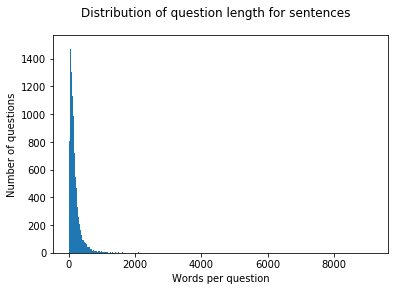

In [36]:
fig = plt.figure()
fig.suptitle('Distribution of question length for sentences')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
plt.hist(sentence_len, bins=1000, log=False)
print("")

31570
31535



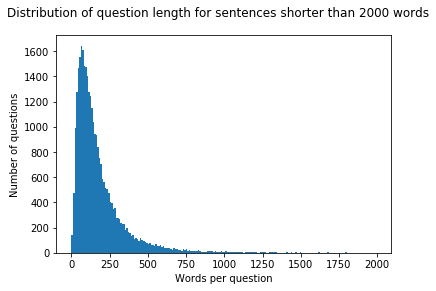

In [37]:
sentence_len_truncated = [a for a in sentence_len if a < 2000]
print(len(sentence_len))
print(len(sentence_len_truncated))
fig = plt.figure()
fig.suptitle(
    'Distribution of question length for sentences shorter than 2000 words')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
plt.hist(sentence_len_truncated, bins=200, log=False)
print("")


In [45]:
# How many questions do we have

# How many questions have answers, and how many answers per question on avg

all_data_df = pd.DataFrame.from_dict(all_data)
all_data_df['sentence_len'] = sentence_len
all_data_df['AnswerCount'] = all_data_df['AnswerCount'].fillna(-1)
all_data_df['PostTypeId'] = all_data_df['PostTypeId'].astype(int)
all_data_df["AnswerCount"] = all_data_df["AnswerCount"].astype(int)
all_data_df['is_question'] = all_data_df['PostTypeId'] == 1


In [20]:
# How many questions are empty
len(all_data_df[all_data_df['sentence_len']==0])

99

In [50]:
# no answers
all_data_df["AnswerCount"].value_counts()

-1     17089
 1      7105
 0      3584
 2      2577
 3       782
 4       263
 5        85
 6        32
 7        14
 8        13
 9         9
 10        5
 11        4
 14        3
 35        1
 12        1
 13        1
 17        1
 15        1
Name: AnswerCount, dtype: int64

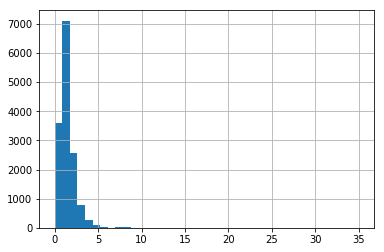

In [52]:
hist = all_data_df[all_data_df["AnswerCount"]!=-1]["AnswerCount"].hist(bins=40)

In [ ]:
# How many questions have accepted answers
# What is the distribution of question scores


In [26]:
grouped = all_data_df[['Id', 'ParentId']].groupby(['ParentId']).count().reset_index()
grouped.sort_values('Id', ascending=False)

,ParentId,Id
1683,155,35
10229,694,17
6226,326,15
933,12851,14
10558,8941,14
6438,334,14
8592,42621,13
2636,19,12
9752,5443,11
977,130,11
